<h1>Cyberbullying detection</h1>
<hr>
<h2>Text Classification NPL<h2>
<hr>
<h3>Proyect 7</h3>
<hr>

In [8]:
#import libraries
import pandas as pd
import matplotlib as plt
import seaborn as sns
import nltk
import gensim 
import pyLDAvis
import wordcloud
import textblob
import spacy
import textstat

from utilerias import missing_values_table
from utilerias import features_by_type

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<hr>
read the dataset
<hr>

In [3]:
df_cbd = pd.read_csv('../datasets/twitter_parsed_dataset.csv')

In [4]:
df_cbd.head()

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [9]:
#let's standarize some features, before to proceed with the EDA
#Eliminate spaces and upper cases from name columns
df_cbd.columns=df_cbd.columns.str.lower().str.replace(' ', '_')


In [7]:
df_cbd.columns

Index(['index', 'id', 'text', 'annotation', 'oh_label'], dtype='object')

In [10]:
table = missing_values_table(df_cbd)
table.style.background_gradient(cmap='Reds')

Sumary :
Columns     :5
Null values :4


,Missing Values,% of Total Values
annotation,3,0.000000
oh_label,3,0.000000
id,1,0.000000
text,1,0.000000


In [11]:
df_cbd[df_cbd['annotation'].isnull()]

,index,id,text,annotation,oh_label
2992,5.67909969783169E+017,5.67909969783169E+017,RT @Lizzethismetal: Probably gonna piss off so...,NaN,NaN
2993,#yesallmen,NaN,NaN,NaN,NaN
2994,@MT8_9 http://t.co/QHo6dhumjc,sexism,1,NaN,NaN


In [19]:
df_cbd[df_cbd['id'].isnull()]

,index,id,text,annotation,oh_label
2993,#yesallmen,NaN,NaN,NaN,NaN


In [16]:
df_cbd[df_cbd['text'].isnull()]

,index,id,text,annotation,oh_label
2993,#yesallmen,NaN,NaN,NaN,NaN


There are 3 rows with some missing features values, I will consider to delete them

take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.

<AxesSubplot:>

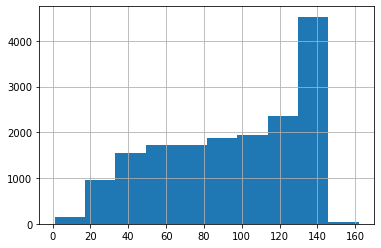

In [20]:
df_cbd['text'].str.len().hist()

Now, let’s plot the number of words appearing in each tweet.

In [22]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
    
plot_word_number_histogram(df_cbd['text'])

TypeError: object of type 'float' has no len()